# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


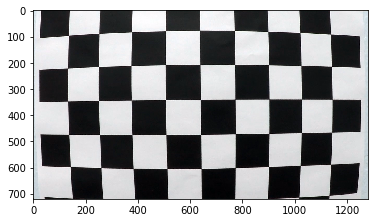

In [2]:
#reading in an image
image = cv2.imread('./camera_cal/calibration1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)   # return image
plt.show()

## Camera Caliberation & Distortion Correction

In [3]:
objpoints = []  # 3D points in realworld 
imgpoints = []  # 2D points from camera images

ret = 0.0
mtx  = np.ndarray([])
dist = np.ndarray([])
rvecs = []
tvecs = []
    
def calibrateCam():
    nx = 9 # corners along each row
    ny = 6 # corners slong each column
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    #Prepare object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    img_cnt = 0
    for fname in images:
        #read image
        image = cv2.imread(fname)
        
        #convert to grayscale
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
#         plt.imshow(gray,cmap='gray')
#         plt.show()
        
        #find corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if(ret==True):
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # draw Chessboard Corners
#             image = cv2.drawChessboardCorners(image,(nx,ny),corners,ret)
#             plt.imshow(image)
#             plt.show()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist
    
def convert2gray(img, fmt = 'BGR'):
    if(fmt == 'RGB'):
        return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Gradient and Direction Threshold 

In [4]:
def abs_sobel_thresh(sobel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
#     if(orient == 'x'):
#         sobel = cv2.Sobel(gray, cv2.CV_64F,1,0,sobel_kernel)
#     elif(orient == 'y'):
#         sobel = cv2.Sobel(gray, cv2.CV_64F,0,1,sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = np.uint8(255.0*sobel_abs/np.max(sobel_abs))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_mask = np.zeros_like(sobel_scaled)
    
    sobel_mask[(sobel_scaled>=thresh[0]) & (sobel_scaled<=thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    grad_binary = sobel_mask    # Apply threshold
    return grad_binary

def mag_thresh(sobel_x, sobel_y, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
        # Apply the following steps to img
        
#     # 2) Take the gradient in x and y separately
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_abs = np.sqrt(np.square(sobel_x)+ np.square(sobel_y))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scaled = np.uint8(255.0*sobel_abs/np.max(sobel_abs))
    
    # 5) Create a binary mask where mag thresholds are met
    sobel_mask = np.zeros_like(sobel_scaled)
    sobel_mask[(sobel_scaled>=mag_thresh[0])&(sobel_scaled<=mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    mag_binary = sobel_mask
    # Apply threshold
    return mag_binary

def dir_threshold(sobel_x, sobel_y, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
#     # 2) Take the gradient in x and y separately
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobel_x)
    sobely_abs = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_dir = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    sobel_mask = np.zeros_like(sobel_dir)
    sobel_mask[(sobel_dir>=thresh[0])&(sobel_dir<=thresh[1])]=1
    # 6) Return this mask as your binary_output image
    dir_binary = sobel_mask
    # Apply threshold
    return dir_binary


## Color Thresholds

In [5]:
def hls_threshold(image, ch = 's', thresh = (180,255)):
    
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    if(ch == 'h'):
        H = hls[:,:,0]
        h_binary = np.zeros_like(H)
        h_binary[(H>=thresh[0])&(H<=thresh[1])] = 1
        return h_binary
    elif(ch == 'l'):
        L = hls[:,:,1]
        l_binary = np.zeros_like(L)
        l_binary[(L>=thresh[0])&(L<=thresh[1])] = 1
        return l_binary
    else:
        S = hls[:,:,2]
        s_binary = np.zeros_like(S)
        s_binary[(S>=thresh[0])&(S<=thresh[1])] = 1
        return s_binary 

def rgb_threshold(image, ch = 'r', thresh = (180,255)):
    rgb = image
    if(ch == 'g'):
        G = rgb[:,:,1]
        g_binary = np.zeros_like(G)
        g_binary[(G>=thresh[0])&(G<=thresh[1])] = 1
        return g_binary
    elif(ch == 'b'):
        B = rgb[:,:,2]
        b_binary = np.zeros_like(B)
        b_binary[(B>=thresh[0])&(B<=thresh[1])] = 1
        return b_binary
    else:
        R = rgb[:,:,0]
        r_binary = np.zeros_like(R)
        r_binary[(R>=thresh[0])&(R<=thresh[1])] = 1
        return r_binary 
    

## Perspective Transform

In [6]:
# src_x = (200,170,605,605)
# src_y = (0,440)
src_x = (200,170,580,580)
src_y = (0,460)
dst_x = (350,1280-320)


def unwarp(img):
    # Pass in your image into this function
    # Write code to do the following steps

    img_size = (img.shape[1],img.shape[0])
    
    # a) define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([[src_x[0],img_size[1]-src_y[0]], [img_size[0]-src_x[1],img_size[1]-src_y[0]], [img_size[0]-src_x[2], src_y[1]], [src_x[3],src_y[1]]]) 
    
    # b) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[dst_x[0],img_size[1]],[dst_x[1],img_size[1]],[dst_x[1],1],[dst_x[0],1]])

    # c) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)

    # d) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
     
    return warped, M, Minv

## Draw region of interest

In [7]:
def draw_roi(img, img_type='src'):
    img_size = (img.shape[1],img.shape[0])
    if(img.ndim==2):
        if(np.amax(img)==1): # in case of binary image - convert to grayscale
            img = img*255
        img = np.dstack([img, img, img]) # convert to rgb to add red region of interest

    if(img_type=='dst'):
        dst = np.float32([[dst_x[0],img_size[1]],[dst_x[1],img_size[1]],[dst_x[1],0],[dst_x[0],0]])
        #Draw out region of interest perimeter on original image
        img_cpy = np.copy(img) # creating a copy of original image to draw region of interest
        cv2.polylines(img_cpy,np.int32([dst]),True,(255,0,0),4)
        return img_cpy, dst

    else:
    # a) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([[src_x[0],img_size[1]-src_y[0]], [img_size[0]-src_x[1],img_size[1]-src_y[0]], [img_size[0]-src_x[2], src_y[1]], [src_x[3],src_y[1]]])   
        #Draw out region of interest perimeter on original image
        img_cpy = np.copy(img) # creating a copy of original image to draw region of interest
        cv2.polylines(img_cpy,np.int32([src]),True,(255,0,0),4)
        return img_cpy, src


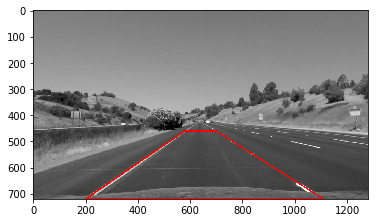

In [8]:
mtx, dist = calibrateCam()
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = undistort(image, mtx, dist)
img_roi, src = draw_roi(image)
plt.imshow(img_roi)
plt.show()

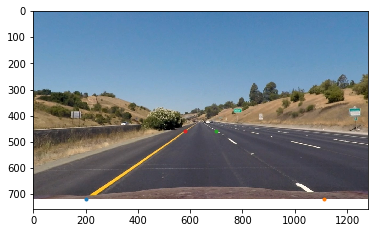

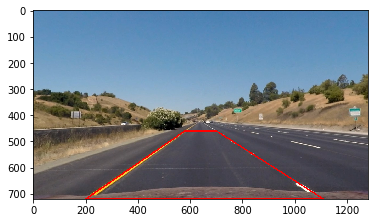

In [9]:
mtx, dist = calibrateCam()
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = undistort(image, mtx, dist)
img_roi, src = draw_roi(image)
plt.imshow(image)
plt.plot(src[0][0],src[0][1],'.')
plt.plot(src[1][0],src[1][1],'.')
plt.plot(src[2][0],src[2][1],'.')
plt.plot(src[3][0],src[3][1],'.')
plt.show()
plt.imshow(img_roi)
plt.show()

## Sliding Window and Polynomial fit

In [10]:
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

def polyFit(binary_warped, histogram, view='None'):
    global left_lane_inds
    global right_lane_inds
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 4) 
#         print('\n',win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 4) 
#         print(win_xright_low,win_y_low,win_xright_high,win_y_high)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
#     if((view=='all') or (view=='slide_window')):
    lane_window = viewSlideWin(binary_warped, out_img, left_fit, right_fit, ploty)
#     if((view=='all') or (view=='lane_poly')):
    lane_poly = viewLanePoly(binary_warped, left_fit, right_fit, ploty, margin)

    return lane_window, lane_poly, left_fit, right_fit, ploty

def polyFit2(binary_warped,left_fit, right_fit, view='None'):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    global left_lane_inds
    global right_lane_inds
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

#     if((view=='all') or (view=='lane_poly')):
    lane_poly = viewLanePoly(binary_warped, left_fit, right_fit, ploty, margin)

    return lane_poly, left_fit, right_fit, ploty

## Visualization Sliding Window

In [11]:
def viewSlideWin(binary_warped, out_img, left_fit, right_fit, ploty):
    global left_lane_inds
    global right_lane_inds
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img
    
def viewLanePoly(binary_warped, left_fit, right_fit, ploty, margin):
    global left_lane_inds
    global right_lane_inds
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

## Radius of Curvature

In [12]:
def curveRadius(binary_warped, left_fit, right_fit, ploty):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
      
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

## Mark Lane

In [13]:
def drawLane(binary_warped, left_fit, right_fit, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('Distance from Center: '+ '<distance>' +'cm')
    cv2.putText(result,str1,(750,10), font, 1,(255,255,255),2,cv2.LINE_AA)
#     if left.radius_of_curvature and right.radius_of_curvature:
#     curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
    str2 = str('Curvature: '+ '<radius>' +'km')
    cv2.putText(result,str2,(750,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result

## Pipeline on Test Images

10176.3141224 9144.29625066
3336.85756585 m 3000.26789964 m
./test_images\straight_lines1.jpg


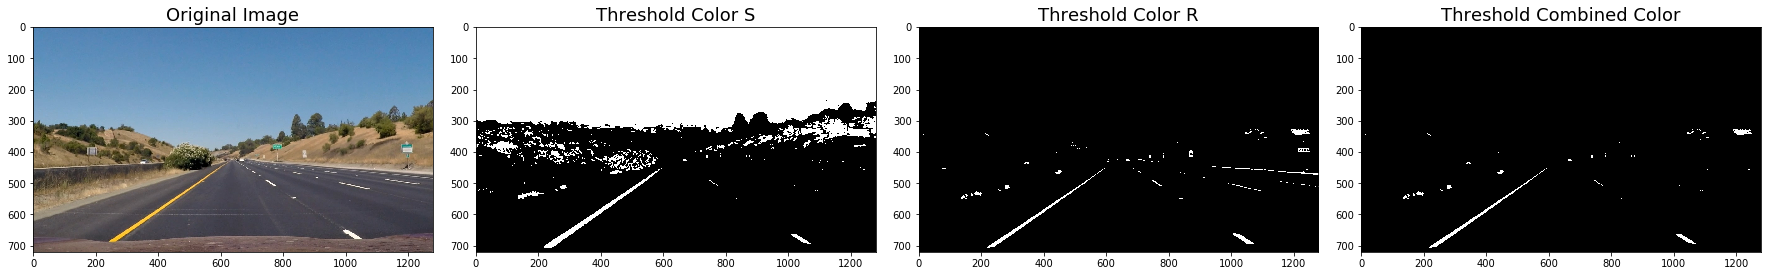

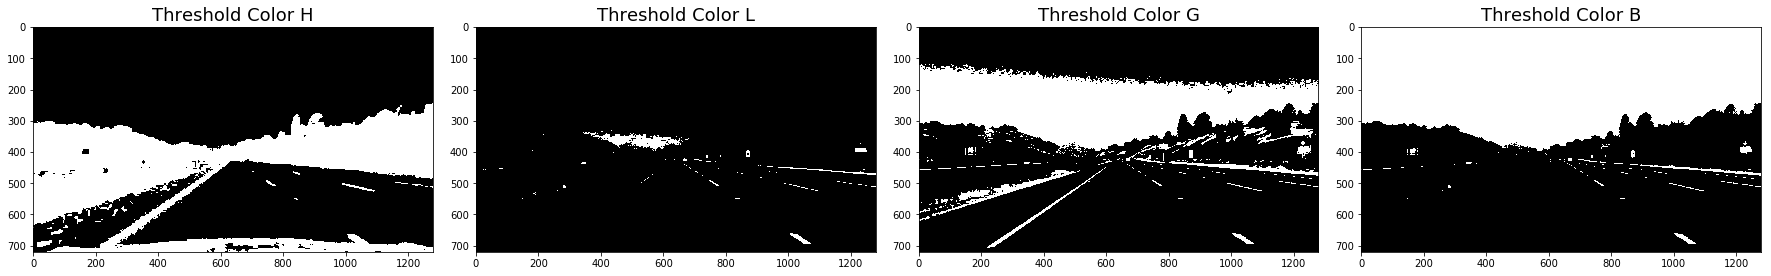

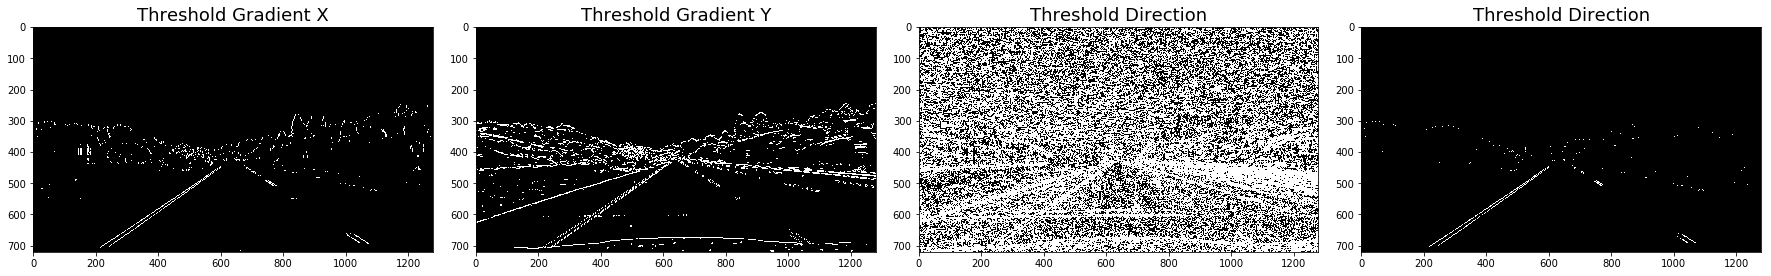

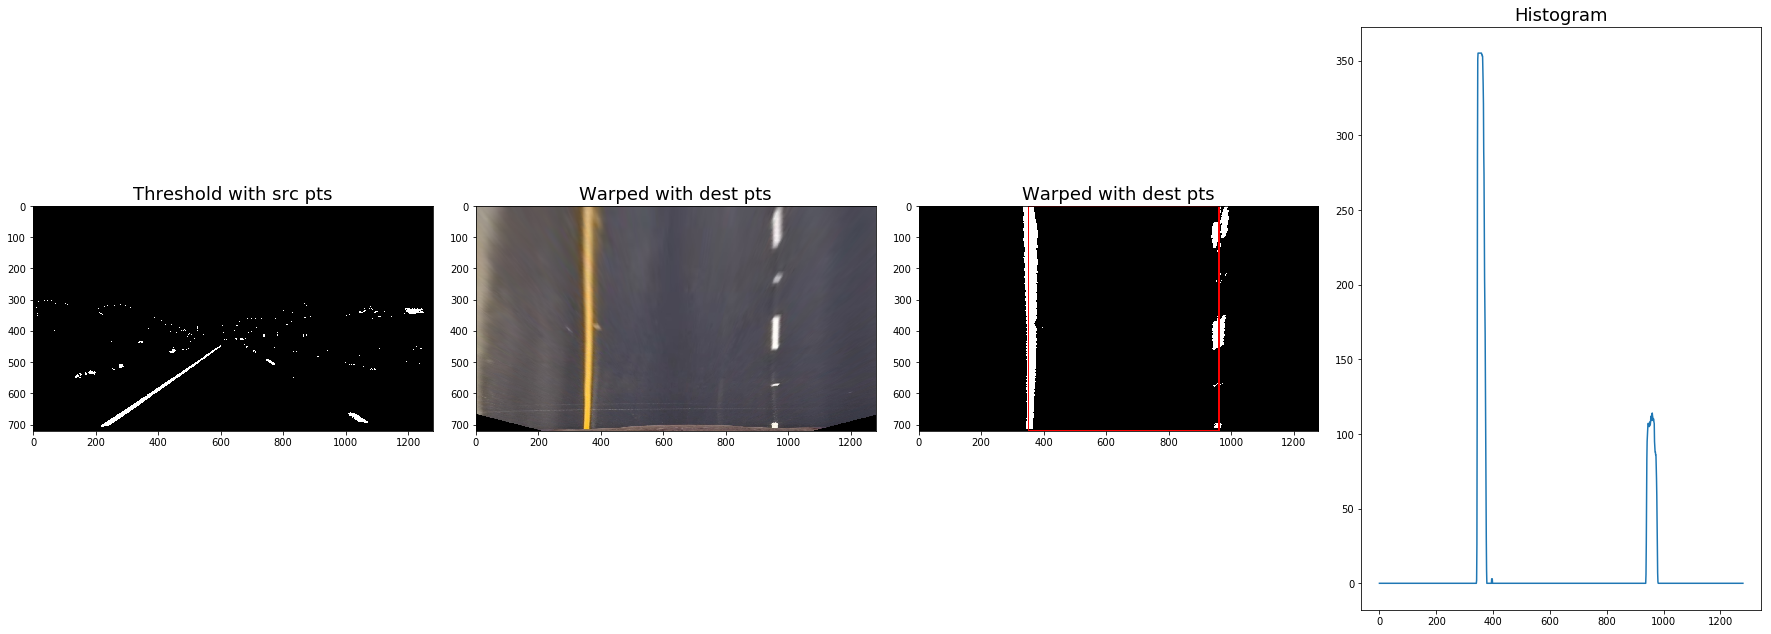

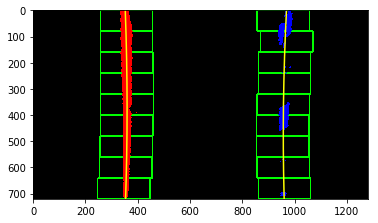

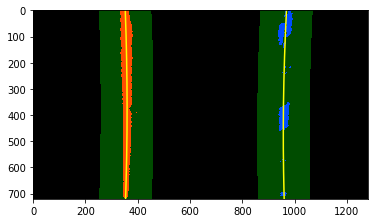

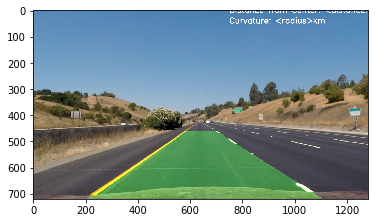

6410.10660227 5473205.00757
2095.3861653 m 1793338.17305 m
./test_images\straight_lines2.jpg


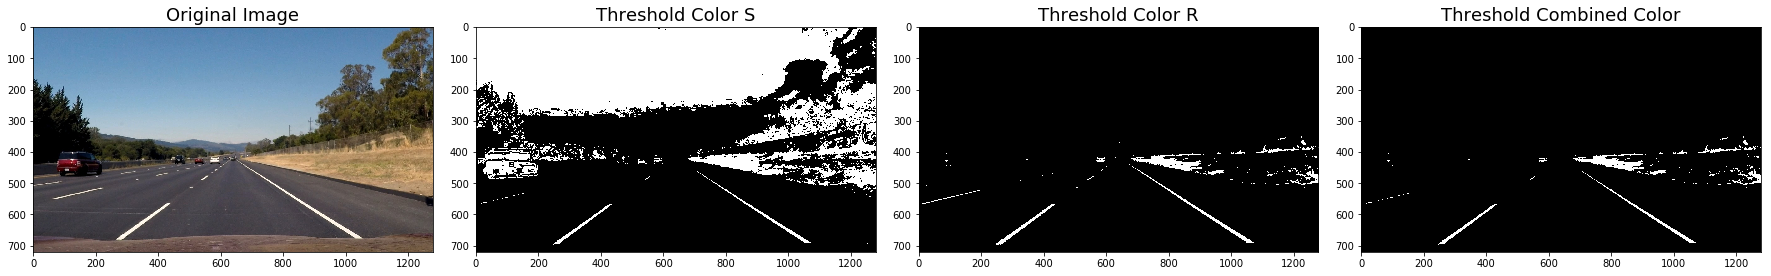

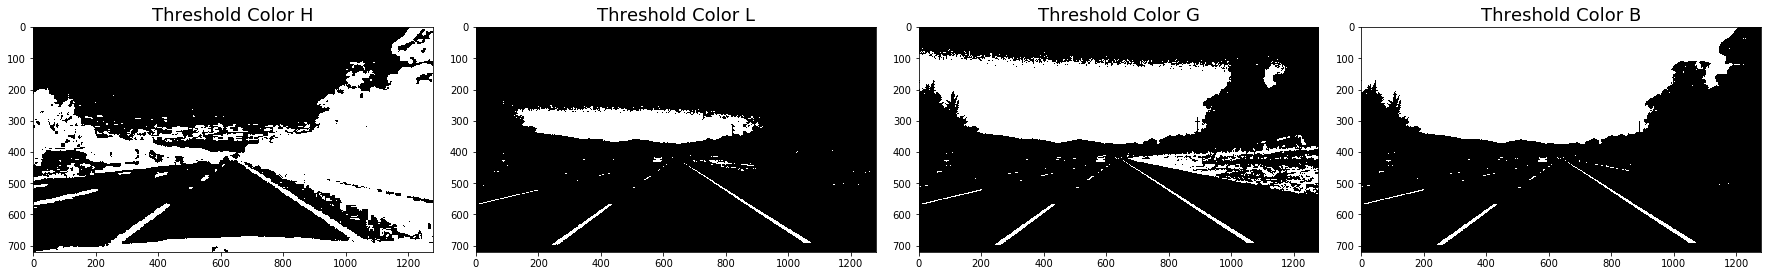

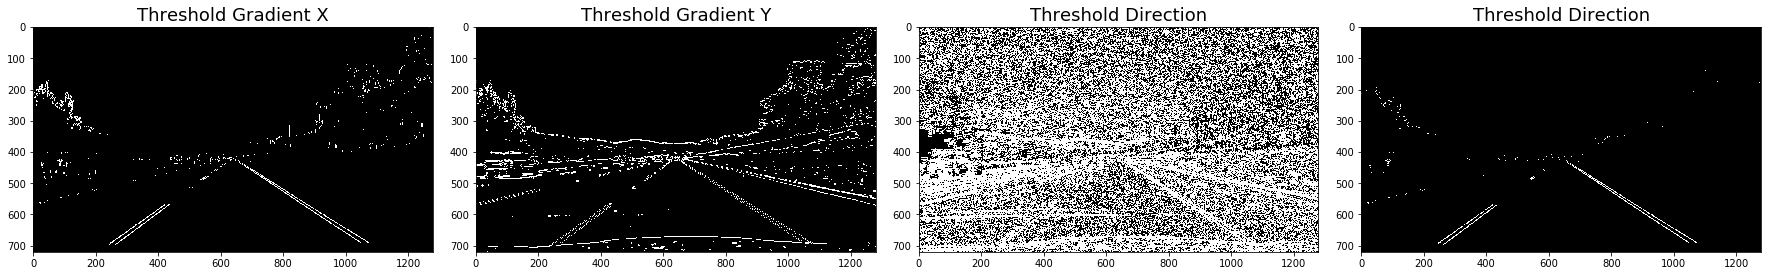

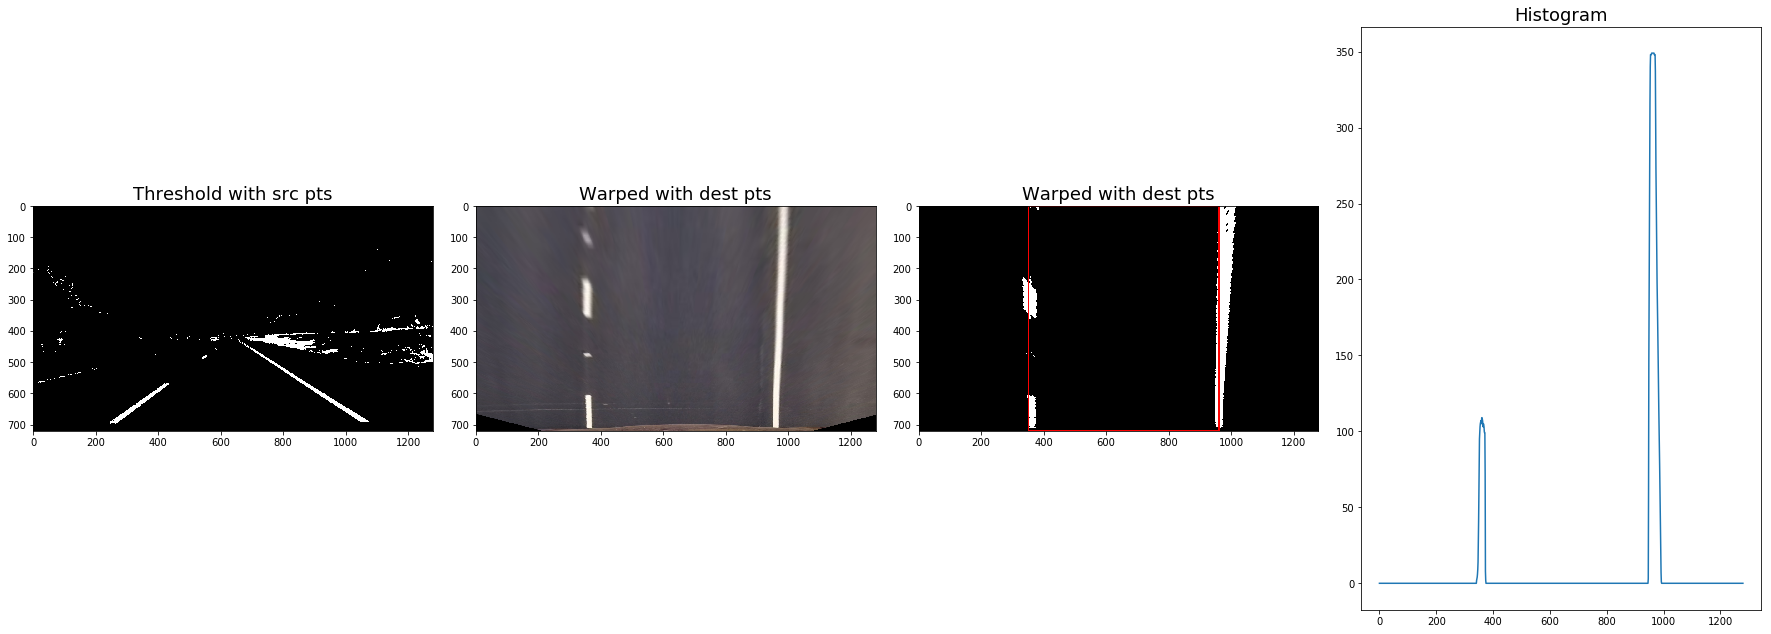

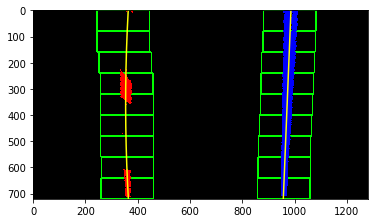

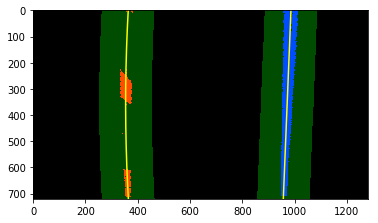

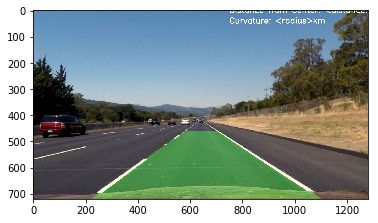

9177.9856077 4299.55981584
3004.1572027 m 1403.2537124 m
./test_images\test1.jpg


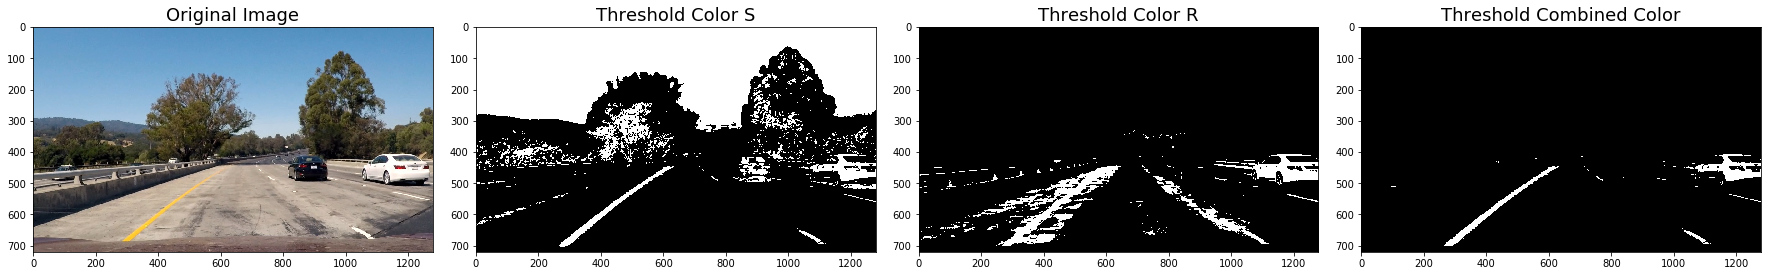

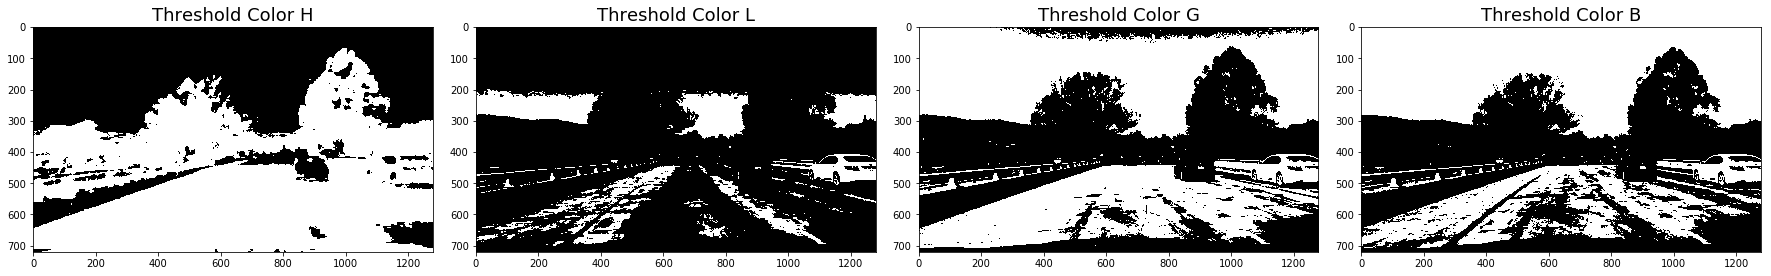

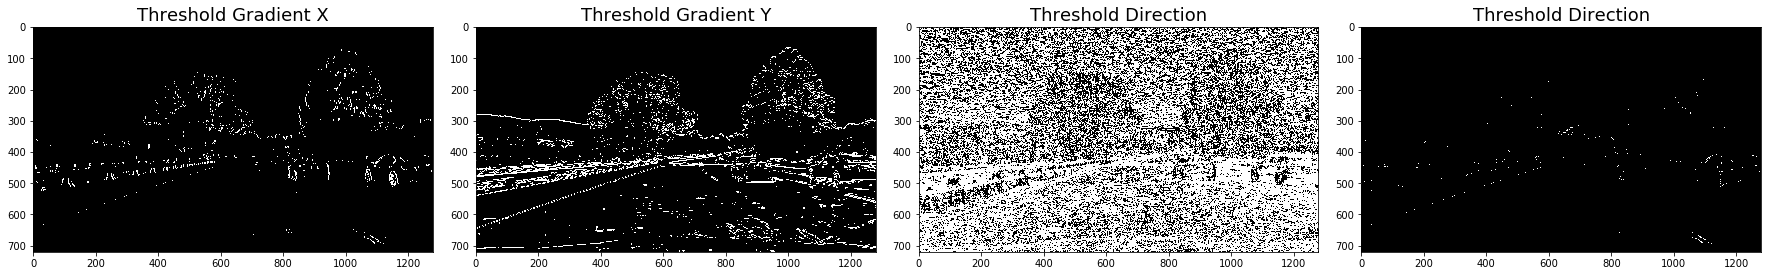

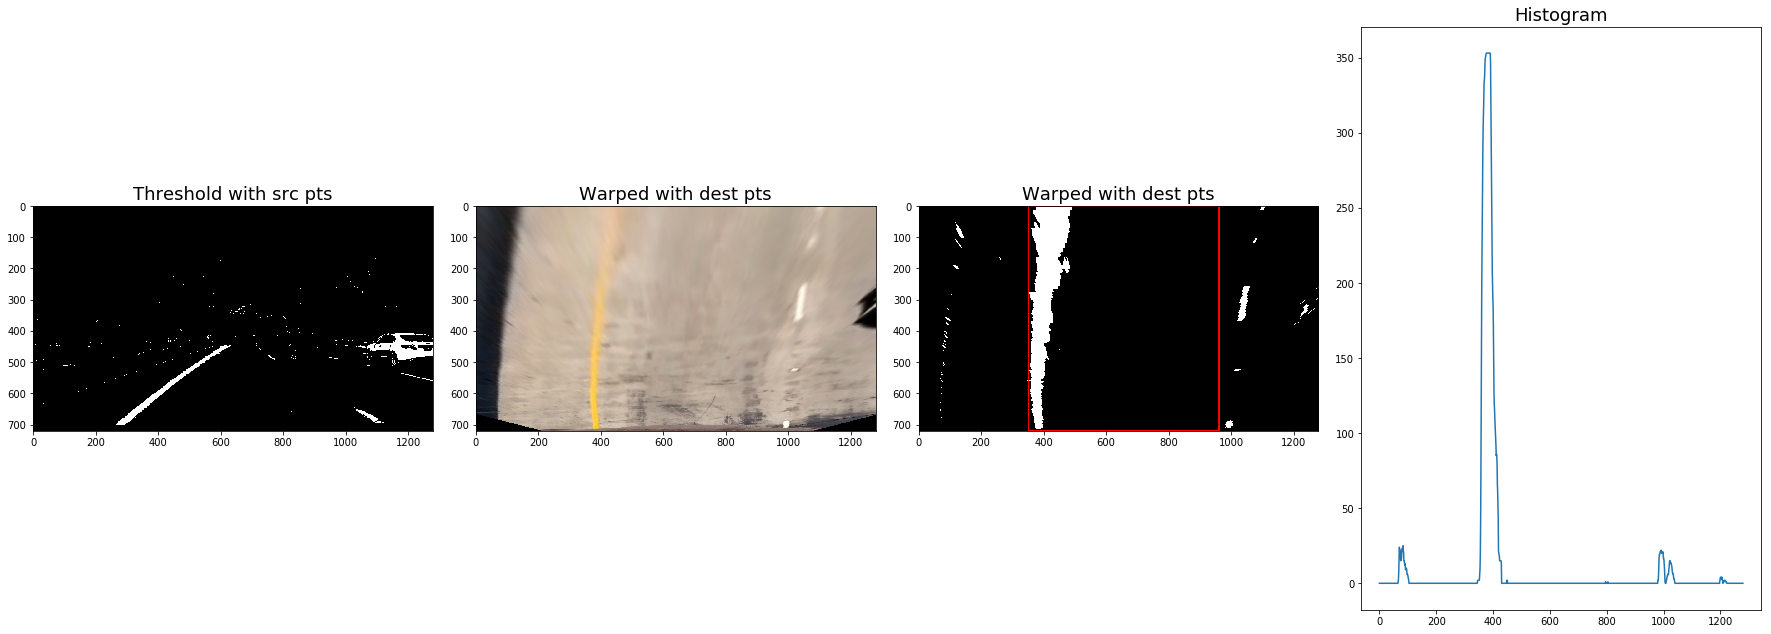

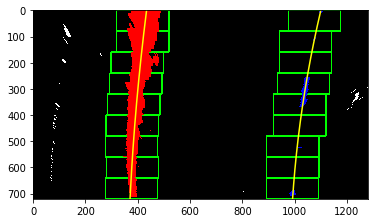

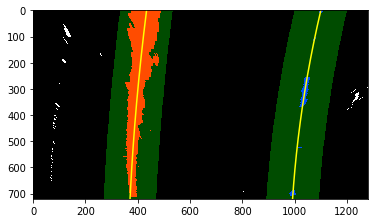

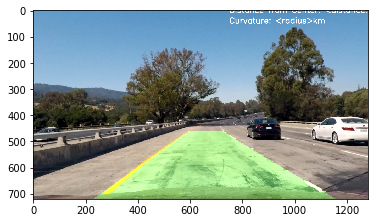

2414.9770039 11701.4421225
793.173184463 m 3615.38733902 m
./test_images\test2.jpg


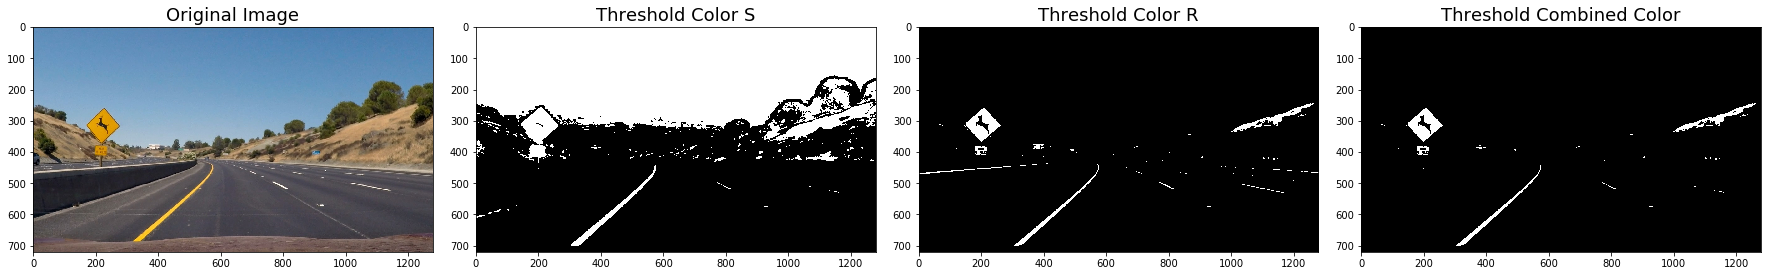

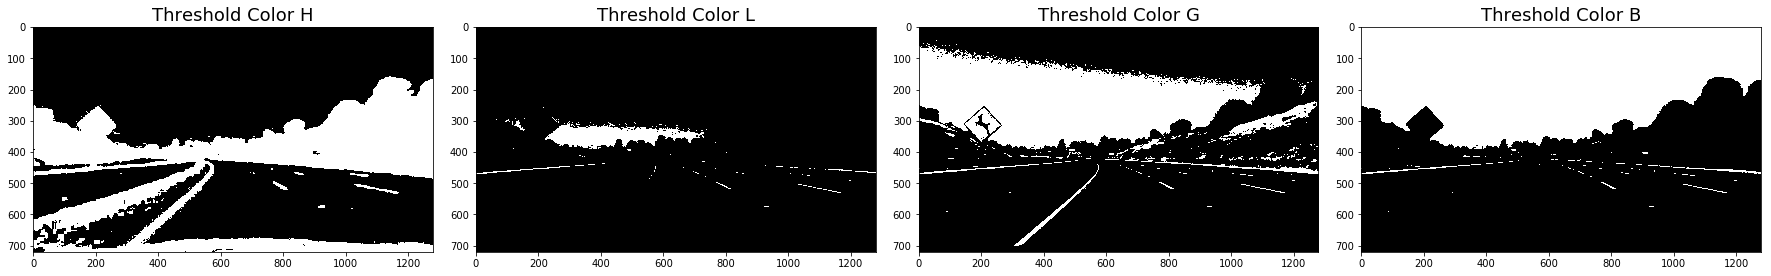

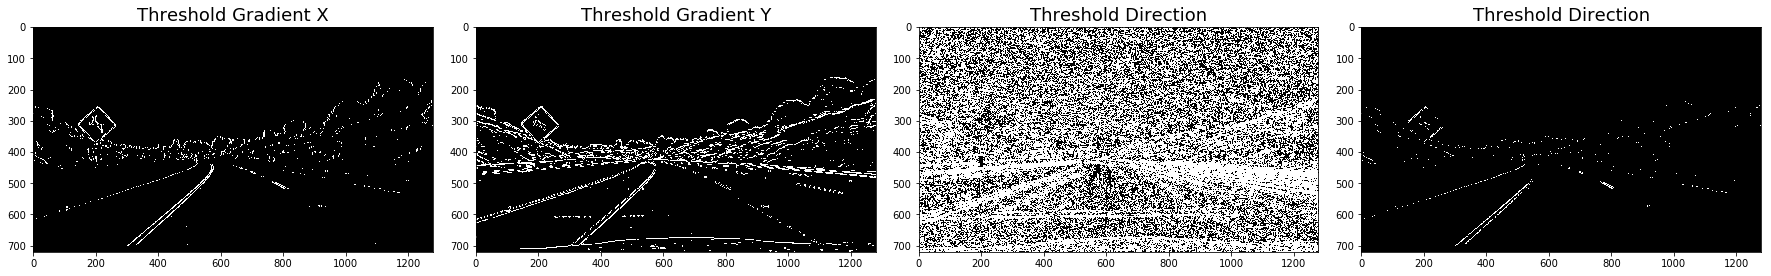

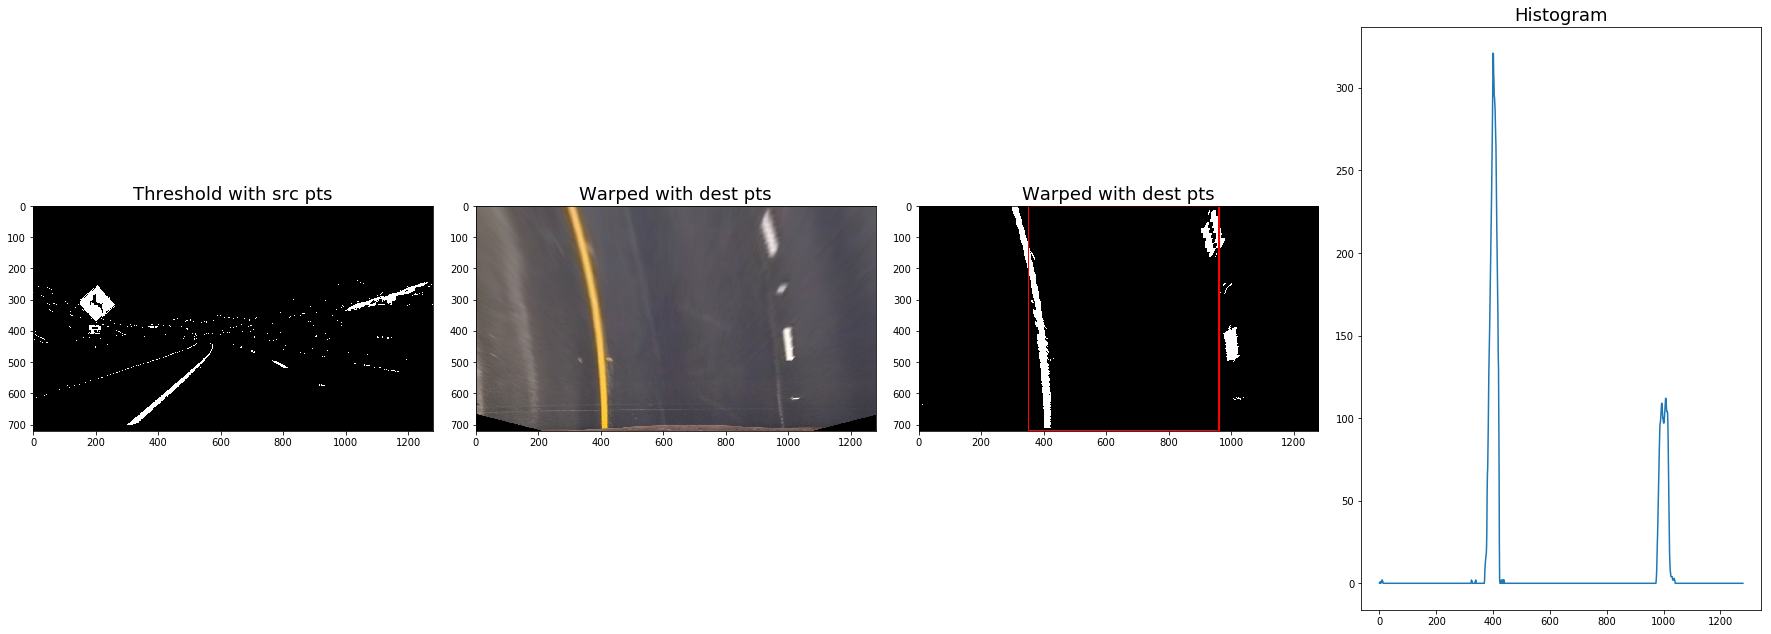

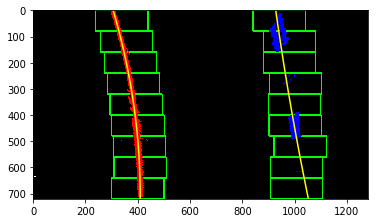

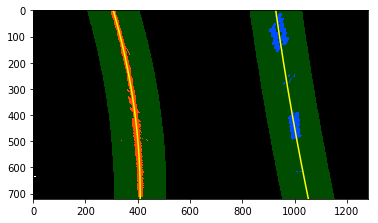

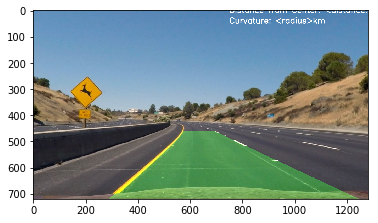

4310.49260246 3548.04240945
1390.20613942 m 1155.99923317 m
./test_images\test3.jpg


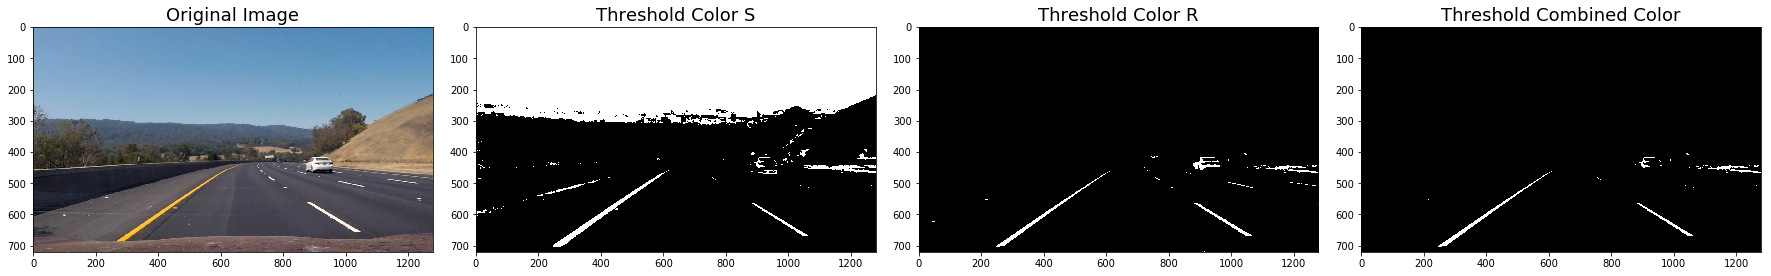

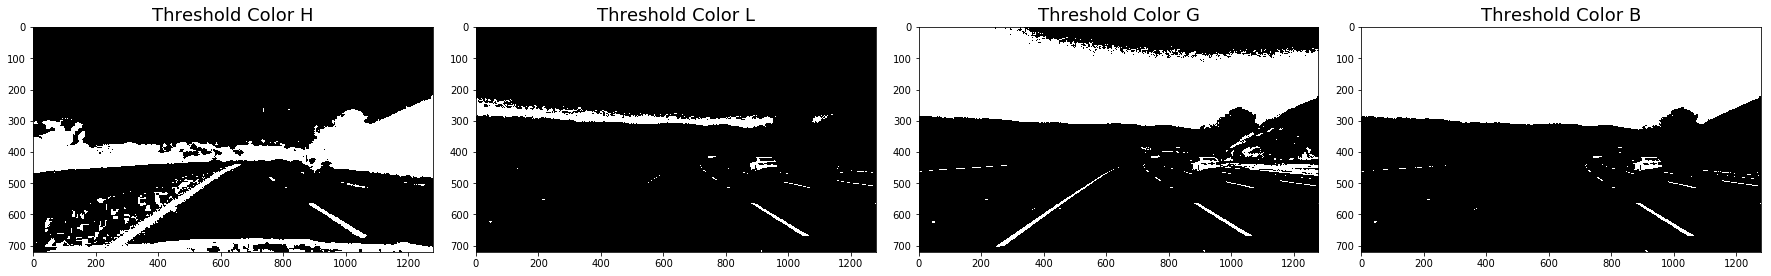

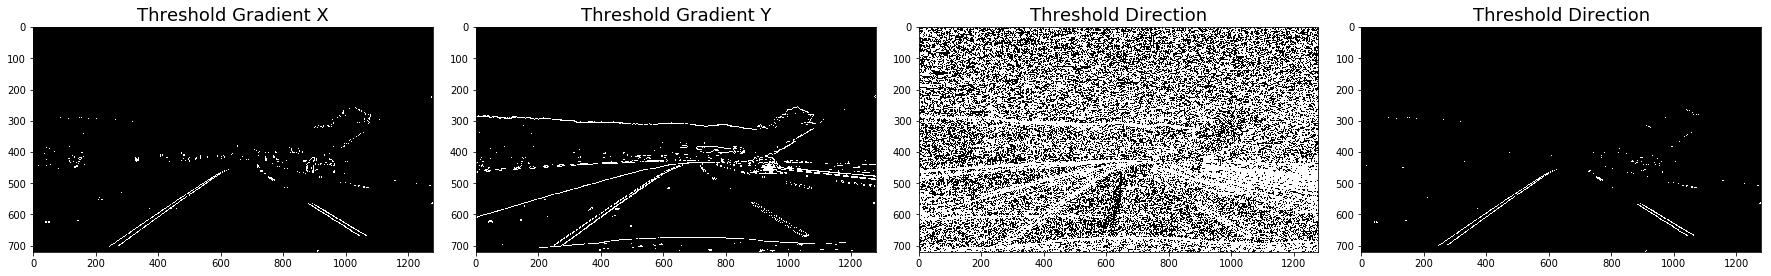

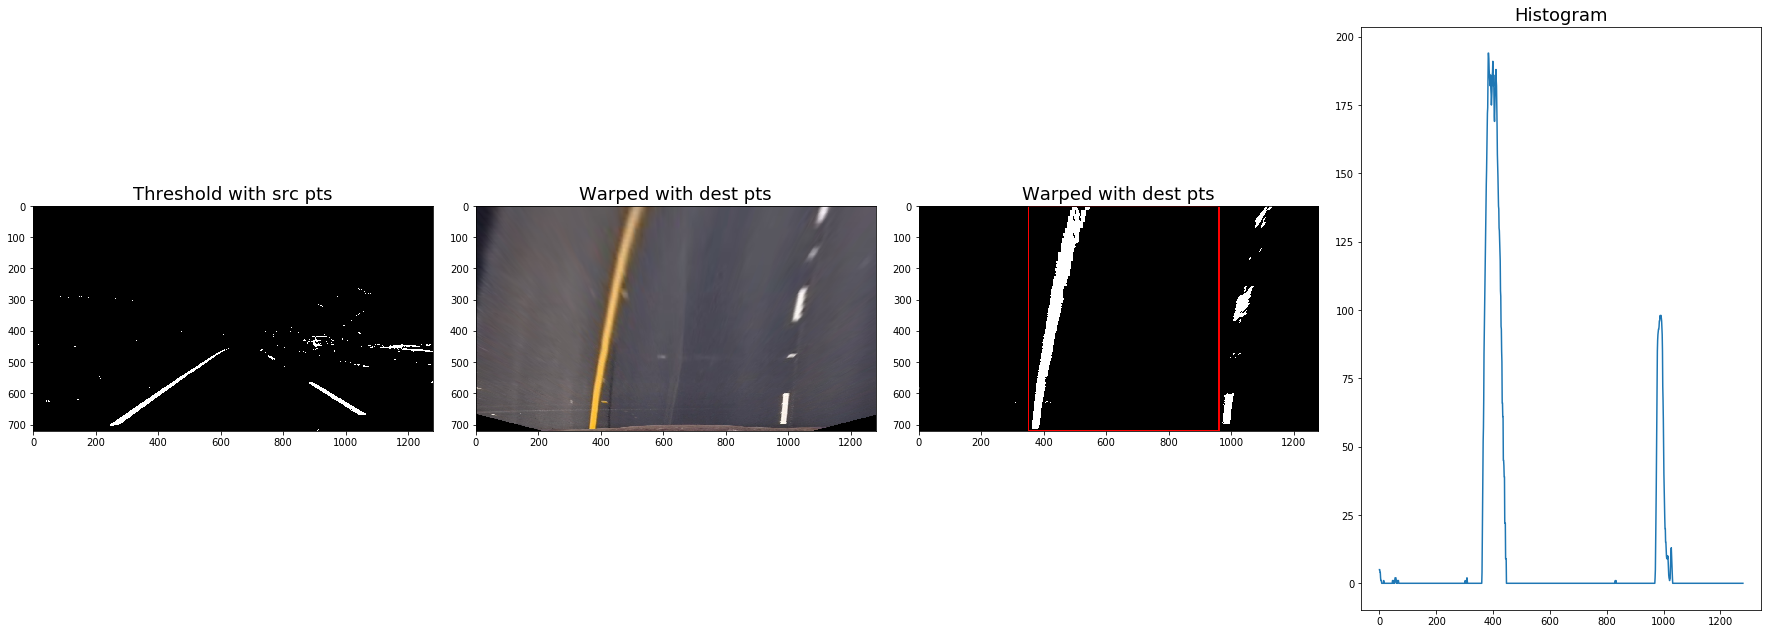

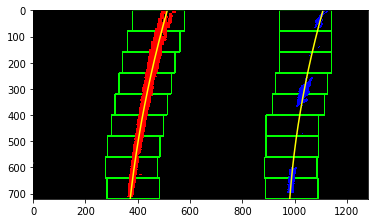

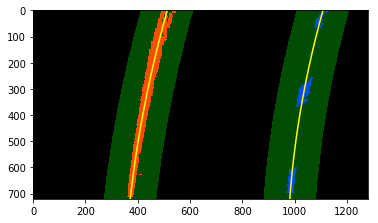

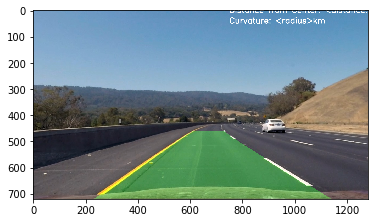

4566.44773324 3150.22784072
1499.42374724 m 1033.57369964 m
./test_images\test4.jpg


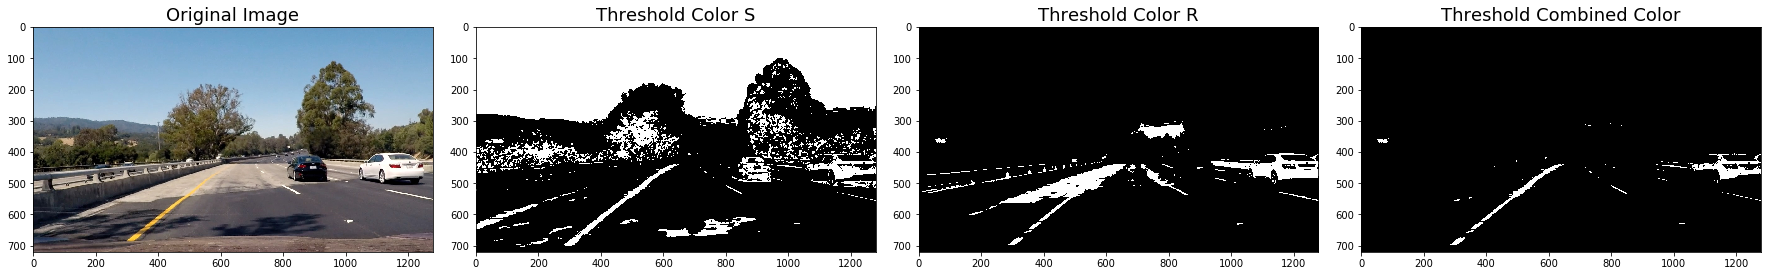

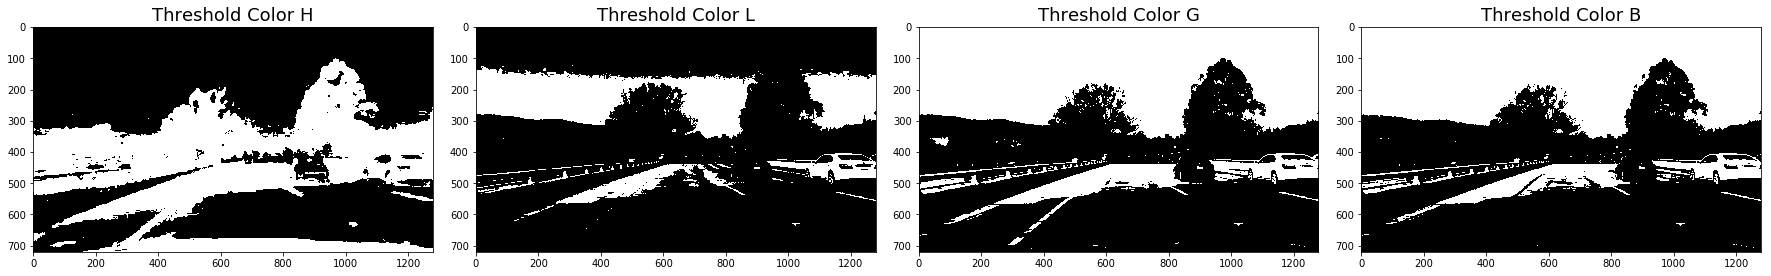

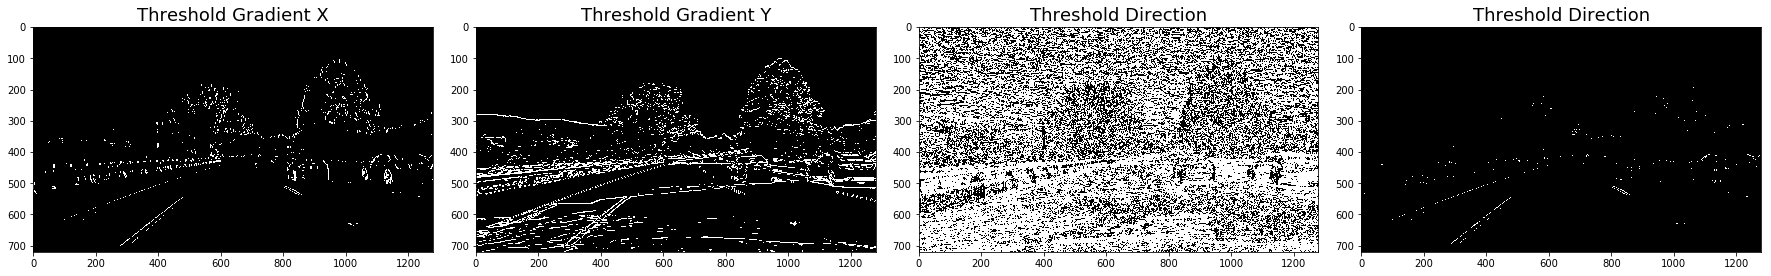

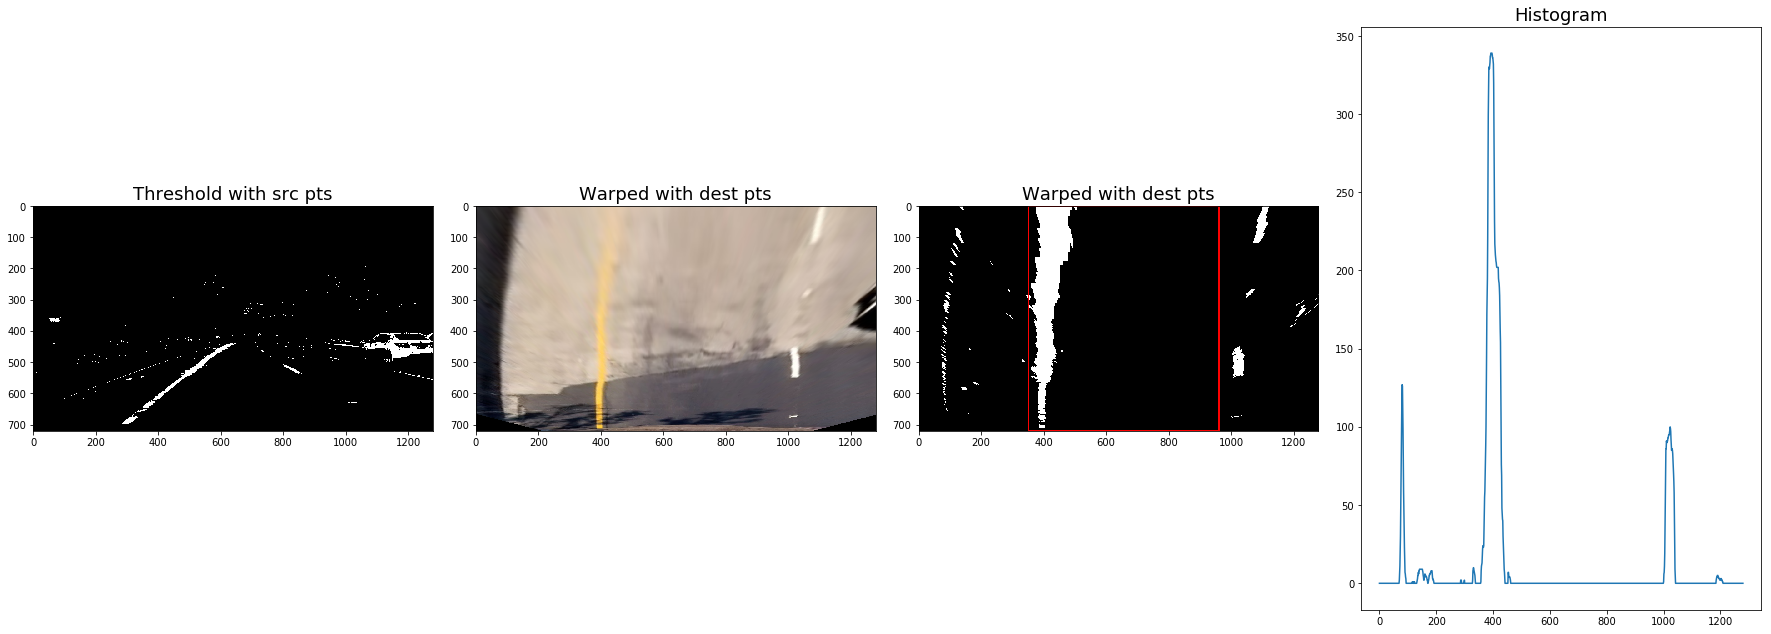

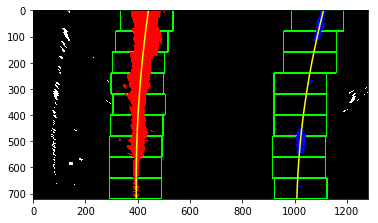

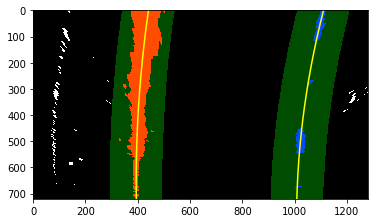

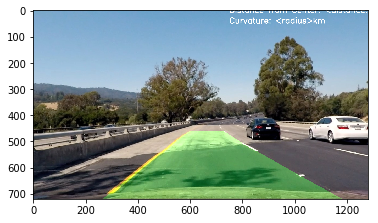

2455.15380048 2055.93834897
806.368765134 m 675.257484932 m
./test_images\test5.jpg


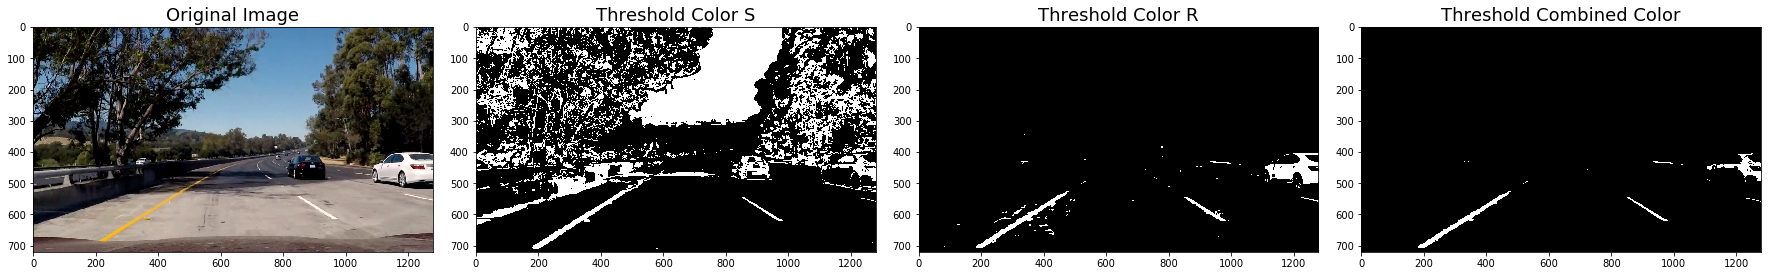

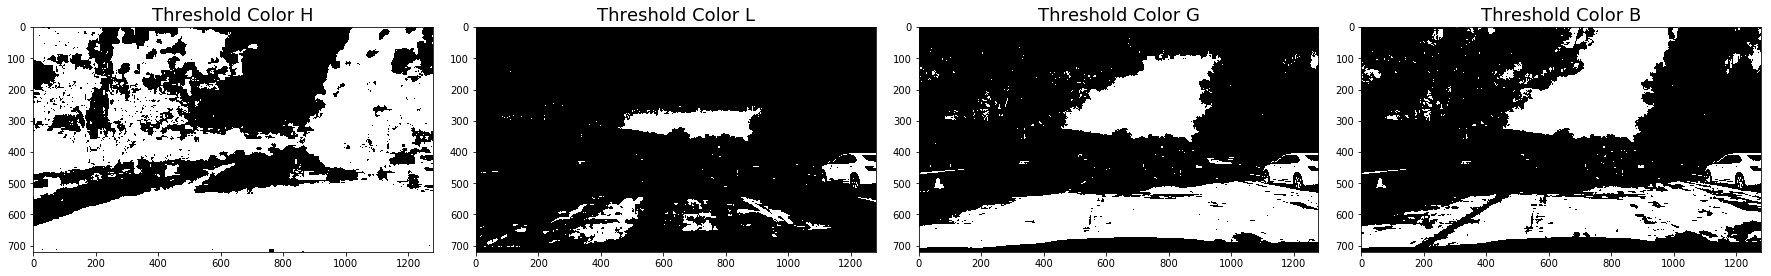

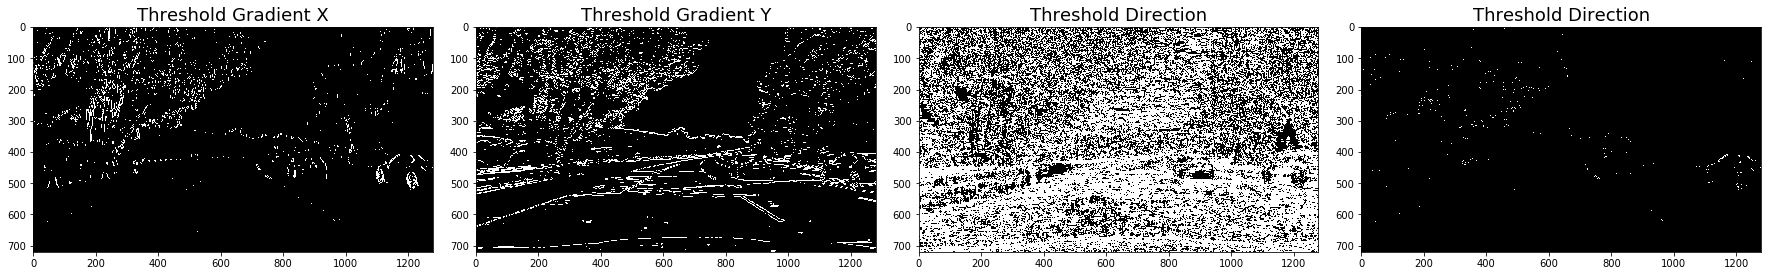

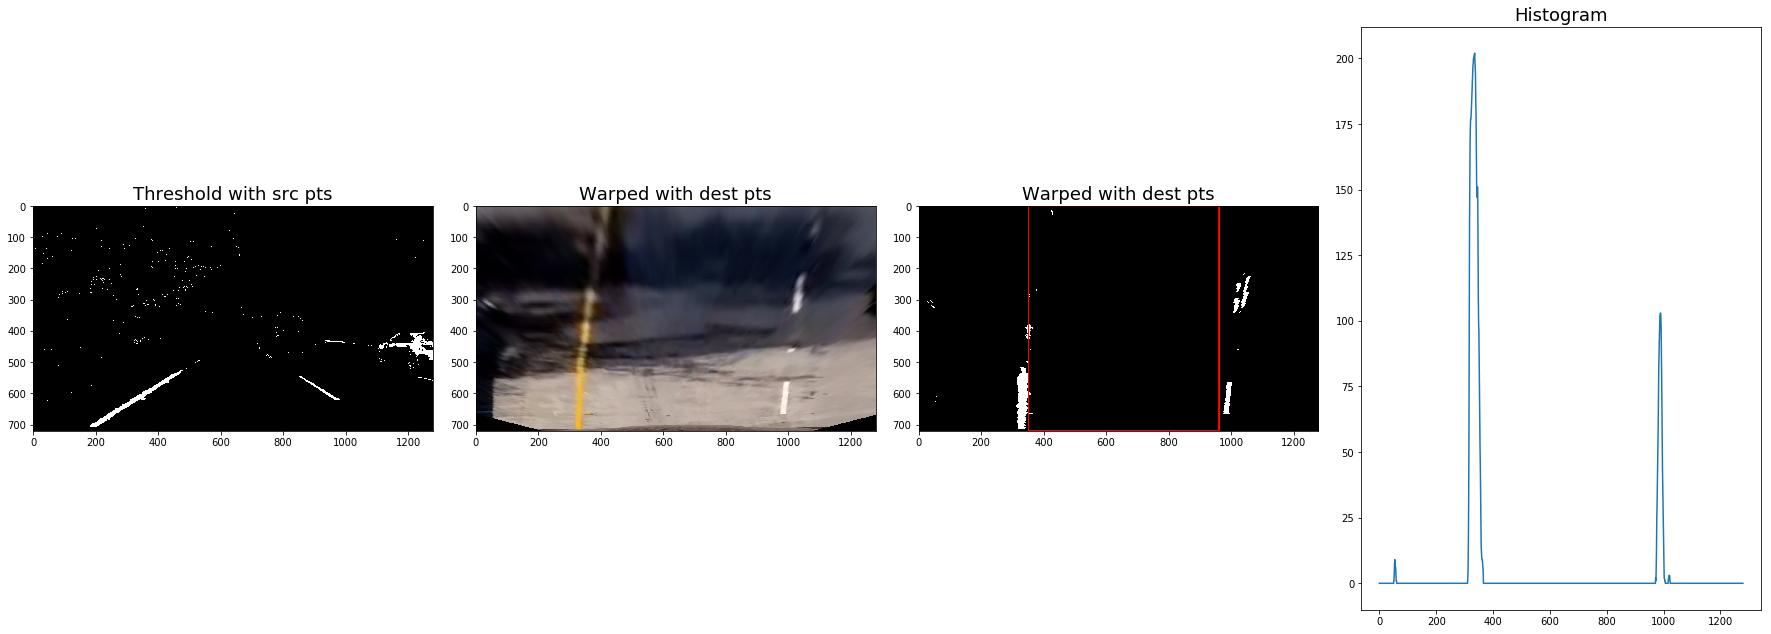

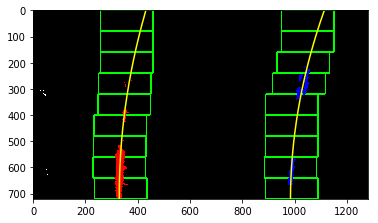

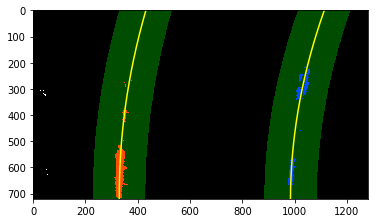

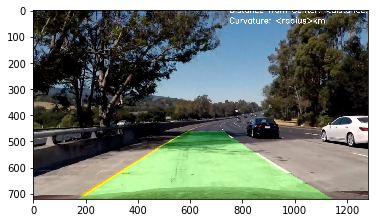

3484.7812171 1212.01500439
1126.88521279 m 383.923227747 m
./test_images\test6.jpg


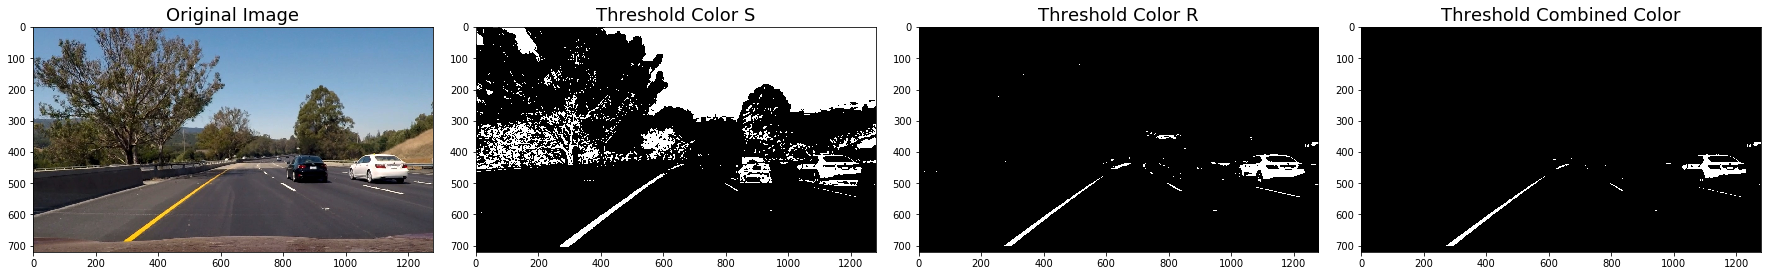

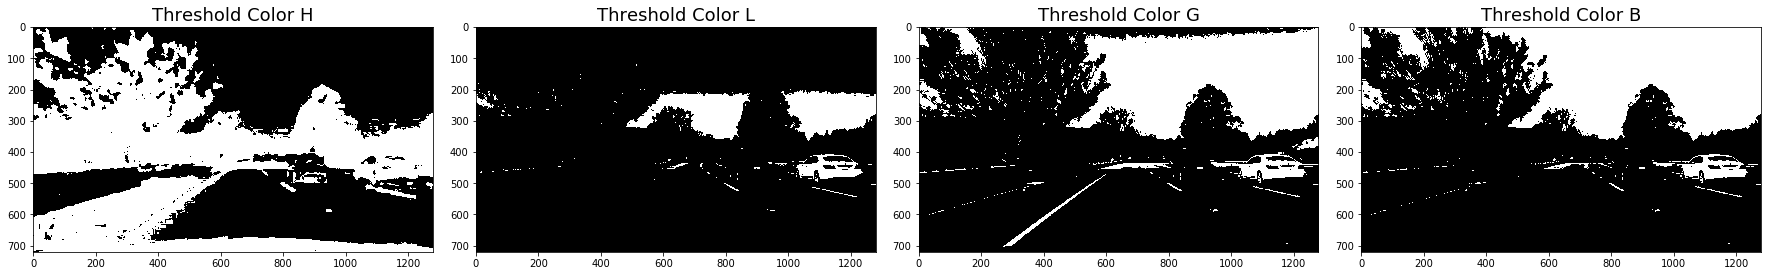

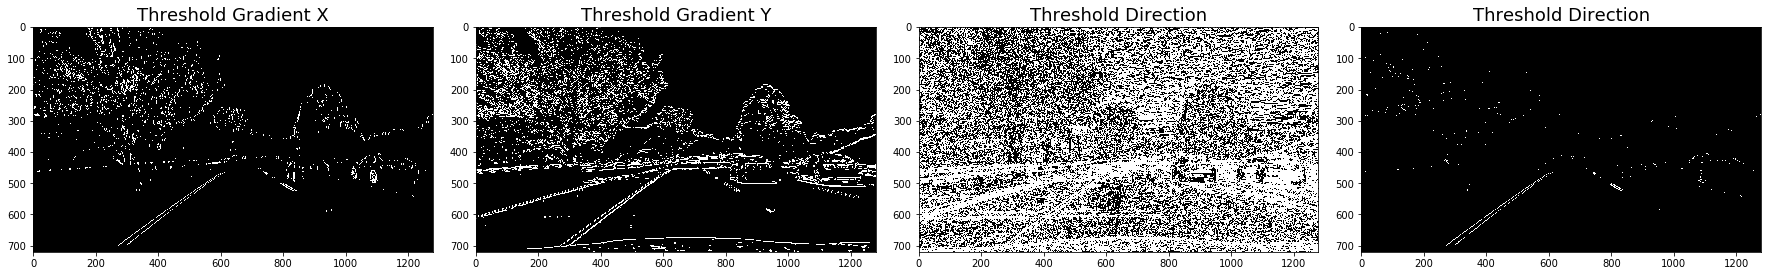

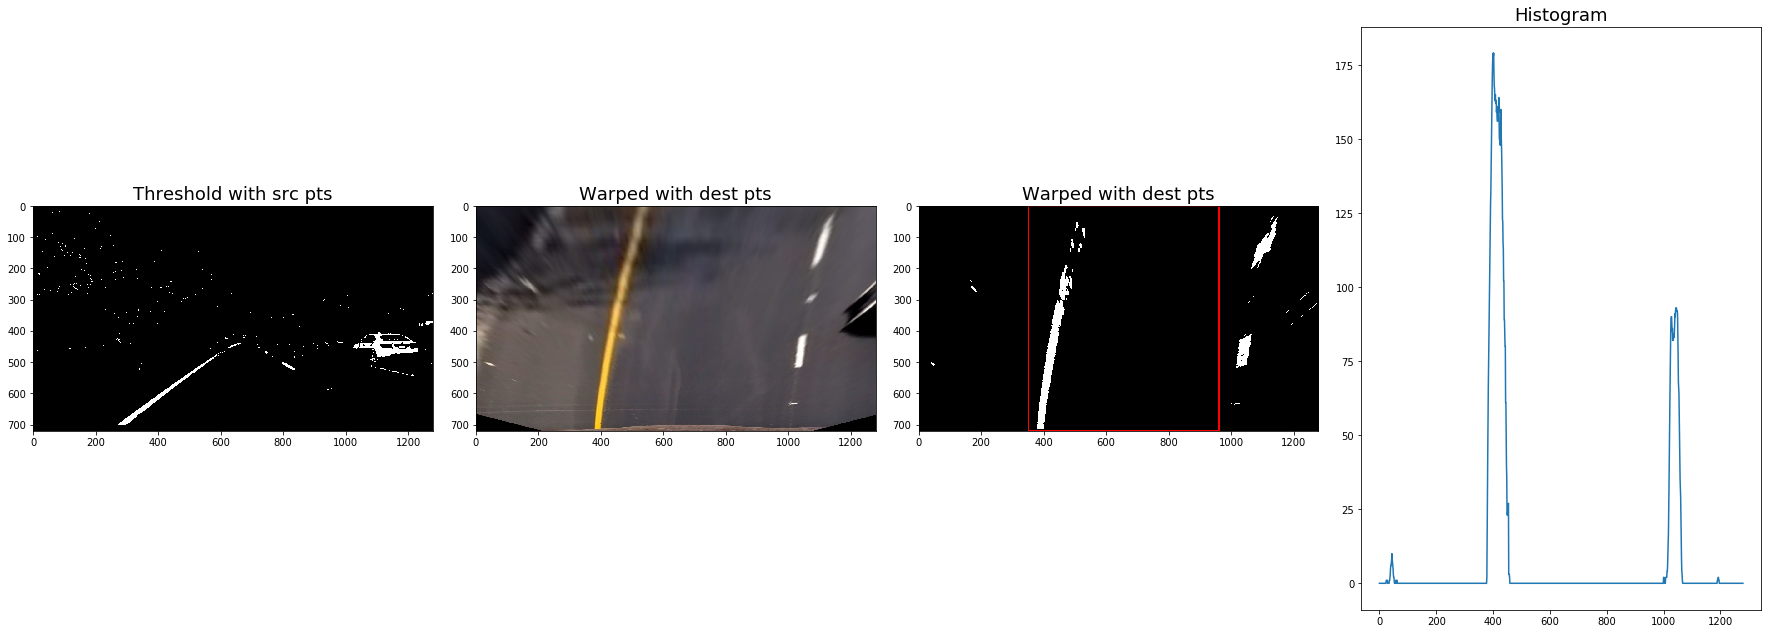

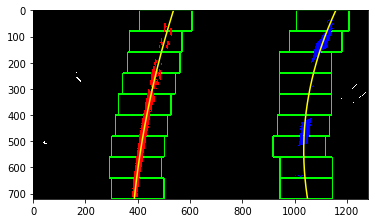

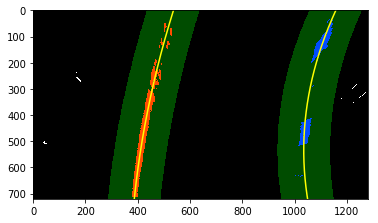

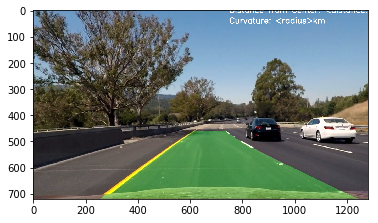

In [14]:
mtx, dist = calibrateCam()
img_cnt=0
images = glob.glob('./test_images/*.jpg')
for fname in images:
    img_cnt+=1
#     if(img_cnt<6 or img_cnt==8):
#         continue
    left_lane_inds = []
    right_lane_inds = []
    
    #read image
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    undist = undistort(image, mtx, dist)
    
    gray_undist = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    sobel_x = cv2.Sobel(gray_undist, cv2.CV_64F, 1, 0, ksize = ksize)
    sobel_y = cv2.Sobel(gray_undist, cv2.CV_64F, 0, 1, ksize = ksize)
    gradx = abs_sobel_thresh(sobel_x, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(sobel_y, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(sobel_x,sobel_y, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(sobel_x,sobel_y, sobel_kernel=15, thresh=(np.pi/4, np.pi/2))
    grad_binary = np.zeros_like(dir_binary)
    grad_binary[((gradx == 1) & (dir_binary == 1))] = 1 # | ((mag_binary == 1) & (dir_binary == 1))] = 1

    #Apply color threshold
#     s_binary = hls_threshold(undist, ch = 's', thresh = (150,255))
    s_binary = hls_threshold(undist, ch = 's', thresh = (90,255))
    h_binary = hls_threshold(undist, ch = 'h', thresh = (0,100))
    l_binary = hls_threshold(undist, ch = 'l', thresh = (180,255))
    
#     r_binary = rgb_threshold(undist, ch = 'r', thresh = (220,255))
    r_binary = rgb_threshold(undist, ch = 'r', thresh = (200,255))
    g_binary = rgb_threshold(undist, ch = 'g', thresh = (150,255))
    b_binary = rgb_threshold(undist, ch = 'b', thresh = (150,255))   
    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) & (r_binary == 1)] = 1

    combined = np.zeros_like(gradx)
    combined[(grad_binary == 1) | (color_binary == 1)] = 1
    combined_src, src = draw_roi(combined, 'src')
    
    color_warped, M, Minv = unwarp(undist)
    binary_warped, M, Minv = unwarp(combined)
    
    top_dst, dst = draw_roi(binary_warped, 'dst')
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
#     if(img_cnt==1):
    lane_window, lane_poly, left_fit, right_fit, ploty = polyFit(binary_warped, histogram, view='all')
#     else:
#         lane_poly, left_fit, right_fit, ploty = polyFit2(binary_warped, left_fit, right_fit, view='all')

    left_curverad, right_curverad = curveRadius(binary_warped, left_fit, right_fit, ploty)
    print(left_curverad, 'm', right_curverad, 'm')
    
    result = drawLane(binary_warped, left_fit, right_fit, ploty, Minv)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print(fname)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image',fontsize=18)
    ax2.imshow(s_binary, cmap='gray')
    ax2.set_title('Threshold Color S',fontsize=18)
    ax3.imshow(r_binary, cmap='gray')
    ax3.set_title('Threshold Color R',fontsize=18)
    ax4.imshow(color_binary, cmap='gray')
    ax4.set_title('Threshold Combined Color',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(h_binary, cmap='gray')
    ax1.set_title('Threshold Color H',fontsize=18)
    ax2.imshow(l_binary, cmap='gray')
    ax2.set_title('Threshold Color L', fontsize=18)
    ax3.imshow(g_binary, cmap='gray')
    ax3.set_title('Threshold Color G',fontsize=18)
    ax4.imshow(b_binary, cmap='gray')
    ax4.set_title('Threshold Color B',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(gradx, cmap='gray')
    ax1.set_title('Threshold Gradient X',fontsize=18)
    ax2.imshow(grady, cmap='gray')
    ax2.set_title('Threshold Gradient Y', fontsize=18)
    ax3.imshow(dir_binary, cmap='gray')
    ax3.set_title('Threshold Direction',fontsize=18)
    ax4.imshow(grad_binary, cmap='gray')
    ax4.set_title('Threshold Direction',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(combined, cmap='gray')
    ax1.set_title('Threshold with src pts',fontsize=18)
    ax2.imshow(color_warped, cmap='gray')
    ax2.set_title('Warped with dest pts', fontsize=18)
    ax3.imshow(top_dst, cmap='gray')
    ax3.set_title('Warped with dest pts', fontsize=18)
    ax4.plot(histogram)
    ax4.set_title('Histogram',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()    
    
    plt.imshow(lane_window)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    plt.imshow(lane_poly)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
        
    plt.imshow(result)
    plt.show()